# **Objective**
What is the objective or goal that you are trying to accomplish? What is the decision that you must make?



1.   Realize a profiling of students in the considered universities center.
2.   Setup a machine learning model that help to indicate to a student, according to his background,
where it should to enroll to maximize her chance to join a quasi-free university.



# **Hypothesis: Research Question?**
 What is the question that you would like to answer in order to make a decision.



1.   What are the main differences betwenn the students of the 3 considered universities

> *   Where they come from
> *   What is their classic background
> *   If needed, the differences betwenn students in the diffents state university faculty





2.   how many universities have the applicants tried to integrate?
3.   The rate of admission according to the number of entities the applicants enrolled.




# **PACKAGES IMPORT**

In [593]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud
import statsmodels
from sklearn import metrics
#from matplotlib import cm
import matplotlib.colors as mcolors


# **Data Source**
Explain where did you get the data. How can you trust this data? Who produced this data and what were their motiviations?


I get data from actual student. The survey is electronically administered to the student of the entities concerned.
* Link to the survey : https://ee.kobotoolbox.org/single/b54ae922228003895f086b690d3c2a78
* Link to the data : *not yet available*




In [594]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [595]:
fulldf = pd.read_excel("/content/drive/MyDrive/DABootcamp/FINAL PROJECT AA/data.xlsx")

In [596]:
print(fulldf.head())
columns = fulldf.columns.to_list()
for el in columns:
  print(el)

  consent repondan      sexe  ...  _submitted_by _tags  _index
0     Oui      Oui  Masculin  ...            NaN   NaN       1
1     Oui      Oui  Masculin  ...            NaN   NaN       2
2     Oui      Oui  Masculin  ...            NaN   NaN       3
3     Oui      Oui   Feminin  ...            NaN   NaN       4
4     Oui      Oui  Masculin  ...            NaN   NaN       5

[5 rows x 107 columns]
consent
repondan
sexe
age
rcom
rcom_other
bdep
bcom
pc
dep_terminal
type_school_f
type_school_f_other
type_school_t
type_school_t_other
system
section
filiere
love_sect
let_level
moyenne
prefac
prefac_org
prefac_org_other
inscri
inscri/ueh
inscri/ctpea
inscri/enst
ueh_fac
ueh_fac/ens
ueh_fac/famv
ueh_fac/fasch
ueh_fac/fds
ueh_fac/fdse
ueh_fac/fe
ueh_fac/fla
ueh_fac/fmp
ueh_fac/fo
ueh_fac/fdsegch
ueh_fac/ierah
ueh_fac/inaghei
raison_famv
raison_fasch
raison_fds
raison_fdse
raison_fe
raison_fla
raison_fmp
raison_fo
raison_fdsegch
raison_ierah
raison_inaghei
raison_ctpea
raison_enst
raison_ens


# **LIST AND FUNCTIONS UTILITIES**

Creating an final output with insights


In [597]:
insights = ""
#variable for the modele trainning
var_for_modeling = []

In [598]:
# import variable name and labels name (in English)

#fulllabels = pd.read_excel(".../")

univ = fulldf['nom_univ1'].unique()
filier = fulldf.filiere.unique()

In [599]:
univ

array(["UEH (Université d'Etat d'Haiti)",
       "CTPEA (Centre de Technique de Planification et d'Economie Appliquée)",
       'ENST (Ecole Nationale Supérieure de Technologie)', nan],
      dtype=object)

In [600]:
filier

array(['SVT (Science de la Vie et de la Terre)', nan,
       'SMP (Science Mathématique et Physique)',
       'SES (Sciences Economiques et Sociales)'], dtype=object)

In [601]:
nomUnivDict = {"UEH (Université d'Etat d'Haiti)": "UEH",
               "CTPEA (Centre de Technique de Planification et d'Economie Appliquée)": "CTPEA",
               'ENST (Ecole Nationale Supérieure de Technologie)': "ENST"}

In [602]:
nomFiliere = {'SVT (Science de la Vie et de la Terre)': "SVT",
              'SMP (Science Mathématique et Physique)': "SMP",
              'SES (Sciences Economiques et Sociales)': "SES"}

In [603]:
fulldf['nom_univ1'] = fulldf['nom_univ1'].replace(nomUnivDict)

In [604]:
fulldf['filiere'] = fulldf['filiere'].replace(nomFiliere)

In [605]:
list_for_ml = ['sexe', 'dep_terminal', 'type_school_f', 'type_school_t', 'section', 'filiere', 'let_level', 'prefac', 'prefac_org', 'parent_revenu', 'let_level',]


## **Utilities for data visualization**

In [606]:
# Functions utilities

def PieChart(data, tit):

  data = data.value_counts(normalize=True)
  length = len(data)
  my_explode = tuple([0.05]*length)
  plt.pie(data, labels=data.index, autopct='%.0f%%', shadow=True, explode=my_explode, )
  plt.title(tit)
  if length>3:
    plt.legend()
  else:
    plt.pie(data, autopct='%.0f%%', shadow=True, explode=my_explode)
  plt.savefig(tit+".png")
  plt.show()

def custo(x):
    """
    This function is created in order to make univariate analysis
    It creates barblot to show distribution of customer from a frequenies table

    """
    # Frequences table
    custo = pd.DataFrame(data.groupby(x)[['repondan']].count())

    ax1 = plt.figure(figsize=(10,8))
   
    plt.barh(custo.index, custo['repondan'] ,edgecolor="black", color = ['slateblue'],)

    
    plt.title('Distribution of customers by '+ x,size=12)

    # Show the proportions
    for i in range(len(custo['repondan'])):
      plt.text(i,2, str(round(custo['repondan'].values[i]/data.shape[0], 2))+"%", fontsize =12, horizontalalignment='center', verticalalignment='top')
    
    #Save the graph
    plt.savefig('Distribution of customers by '+ x + ".png")
    return custo




# **Data Cleaning**

No data cleanning really needed, but some check is done here for the constraint we forget to put in the survey conception.

## **Analytical Transformations**
Perform any transformation on the columns in the dataset to enable further analysis.

In [607]:
# if the year indicated by the student is higher than the duration of his study,
# it is considered that the student is in his last year
fulldf['anne1'] = np.where(fulldf['anne1'] < fulldf['duree'], fulldf['duree'], fulldf['anne1'])


# removing the metadata
fulldf = fulldf.iloc[:, :-10]


In [608]:
# For logistic regression

fulldf['yCTPEA'] = fulldf.admission.apply(lambda x : 1 if x == "CTPEA" else 0)
fulldf['yENST'] = fulldf.admission.apply(lambda x : 1 if x == "CTPEA" else 0)
fulldf['yUEH'] = fulldf.admission.apply(lambda x : 1 if x == "CTPEA" else 0)


fulldf['depdiff'] = fulldf.bdep==fulldf.dep_terminal

In [609]:
fulldf.columns.to_list()

['consent',
 'repondan',
 'sexe',
 'age',
 'rcom',
 'rcom_other',
 'bdep',
 'bcom',
 'pc',
 'dep_terminal',
 'type_school_f',
 'type_school_f_other',
 'type_school_t',
 'type_school_t_other',
 'system',
 'section',
 'filiere',
 'love_sect',
 'let_level',
 'moyenne',
 'prefac',
 'prefac_org',
 'prefac_org_other',
 'inscri',
 'inscri/ueh',
 'inscri/ctpea',
 'inscri/enst',
 'ueh_fac',
 'ueh_fac/ens',
 'ueh_fac/famv',
 'ueh_fac/fasch',
 'ueh_fac/fds',
 'ueh_fac/fdse',
 'ueh_fac/fe',
 'ueh_fac/fla',
 'ueh_fac/fmp',
 'ueh_fac/fo',
 'ueh_fac/fdsegch',
 'ueh_fac/ierah',
 'ueh_fac/inaghei',
 'raison_famv',
 'raison_fasch',
 'raison_fds',
 'raison_fdse',
 'raison_fe',
 'raison_fla',
 'raison_fmp',
 'raison_fo',
 'raison_fdsegch',
 'raison_ierah',
 'raison_inaghei',
 'raison_ctpea',
 'raison_enst',
 'raison_ens',
 'admission',
 'admission/ueh',
 'admission/ctpea',
 'admission/enst',
 'ueh_fac_admission',
 'ueh_fac_admission/ens',
 'ueh_fac_admission/famv',
 'ueh_fac_admission/fasch',
 'ueh_fac_ad

In [610]:
fulldf.head()

,consent,repondan,sexe,age,rcom,rcom_other,bdep,bcom,pc,dep_terminal,type_school_f,type_school_f_other,type_school_t,type_school_t_other,system,section,filiere,love_sect,let_level,moyenne,prefac,prefac_org,prefac_org_other,inscri,inscri/ueh,inscri/ctpea,inscri/enst,ueh_fac,ueh_fac/ens,ueh_fac/famv,ueh_fac/fasch,ueh_fac/fds,ueh_fac/fdse,ueh_fac/fe,ueh_fac/fla,ueh_fac/fmp,ueh_fac/fo,ueh_fac/fdsegch,ueh_fac/ierah,ueh_fac/inaghei,...,ueh_fac_admission/fasch,ueh_fac_admission/fds,ueh_fac_admission/fdse,ueh_fac_admission/fe,ueh_fac_admission/fla,ueh_fac_admission/fmp,ueh_fac_admission/fo,ueh_fac_admission/fdsegch,ueh_fac_admission/ierah,ueh_fac_admission/inaghei,paf,nb_sup1,nb_univ,univ_1,nom_univ1,option1,fac1,anne1,nb_reprises,duree,univ_2,nom_univ2,nonuniv22,option2,fac2,anne2,nb_reprises2,duree2,family,family_mono,money,scolarite_parent,scolarite_paid,scolarite_paid_other,parent_revenu,left,yCTPEA,yENST,yUEH,depdiff
0,Oui,Oui,Masculin,20.0,Tabarre,NaN,Ouest,Delmas,Non,Ouest,Privee,NaN,Privee,NaN,Nouveau Secondaire,NaN,SVT,Non,Meilleur(e) en lettre/mémorisation qu'en chiffre,7.0,Oui,other,Vip préfac,UEH (Université d'Etat d'Haiti),1.0,0.0,0.0,"Institut National d’Administration, de Gestion...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Non,NaN,NaN,UEH,NaN,"Institut National d’Administration, de Gestion...",4.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oui,Non,Non,Oui,NaN,NaN,Oui,Oui,0,0,0,True
1,Oui,Oui,Masculin,25.0,Port-au-Prince,NaN,Centre,Thomonde,Oui,Ouest,"Congréganiste (Frères, Soeurs)",NaN,"Congréganiste (Frères, Soeurs)",NaN,Traditionnelle,D,NaN,Non,J'étais cale en chiffre et en lettre/mémorisation,8.0,Oui,UEH (Université d'Etat d'Haiti),NaN,UEH (Université d'Etat d'Haiti) CTPEA (Centre ...,1.0,1.0,0.0,ENS (Ecole Normale Supérieure) Faculté des Sci...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Non,NaN,NaN,CTPEA,Statistique,NaN,4.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non,NaN,Non,Oui,NaN,NaN,Oui,Oui,0,0,0,False
2,Oui,Oui,Masculin,22.0,Port-au-Prince,NaN,Ouest,Port-au-Prince,Oui,Ouest,"Congréganiste (Frères, Soeurs)",NaN,"Congréganiste (Frères, Soeurs)",NaN,Traditionnelle,C,NaN,Oui,J'étais cale en chiffre et en lettre/mémorisation,7.0,Oui,UEH (Université d'Etat d'Haiti),NaN,UEH (Université d'Etat d'Haiti) CTPEA (Centre ...,1.0,1.0,0.0,Faculté des Sciences (FDS) Faculté de Droit et...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non,NaN,NaN,CTPEA,Economie ou planification (pour les étudiants ...,NaN,4.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oui,Non,Oui,Non,Je paie mes frais de scolarité,NaN,Non,Oui,0,0,0,True
3,Oui,Oui,Feminin,20.0,Croix-des Bouquets,NaN,Ouest,Delmas,Oui,Ouest,"Congréganiste (Frères, Soeurs)",NaN,"Congréganiste (Frères, Soeurs)",NaN,Nouveau Secondaire,NaN,SVT,Non,Meilleur(e) en lettre/mémorisation qu'en chiffre,7.0,Oui,other,Étudiants pour la plupart à Quiskeya et Notre ...,UEH (Université d'Etat d'Haiti),1.0,0.0,0.0,"Institut National d’Administration, de Gestion...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Non,NaN,NaN,UEH,NaN,"Institut National d’Administration, de Gestion...",4.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oui,Non,Non,Oui,NaN,NaN,Oui,Oui,0,0,0,True
4,Oui,Oui,Masculin,22.0,Port-au-Prince,NaN,Ouest,Port-au-Prince,Oui,Ouest,Lycee,NaN,Lycee,NaN,Traditionnelle,C,NaN,Non,Balance(e),6.0,Oui,ENST (Ecole Nationale Supérieure de Technologie),NaN,UEH (Université d'Etat d'Haiti) ENST (Ecole Na...,1.0,0.0,1.0,Faculté de Droit et des Sciences Economiques (...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Non,NaN,NaN,ENST,NaN,NaN,3.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oui,Non,Oui,Oui,NaN,NaN,Oui,Oui,0,0,0,True


In [611]:
fulldf['nb_inscriptions']  = fulldf['inscri/ueh'] + fulldf['inscri/ctpea'] + fulldf['inscri/enst']

## **Review data types**
Inspect the dataset for the data types of each column.

## **Treatment of Missing Values**
If there are any missing values, how do you plan to treat those data columns?

# **Data Analysis**
Explore the dataset to discover relationships between records or columns and patterns within the data.

## **Descriptive Statistical Analysis**
Using basic statistical measures such as measurements of central tendancy such as mean, median and mode.

### **Distribution of Variables**
Identify the distribution of the data to understand the range of values and how the data is structured.

### **Outliers in the dataset**
Identify if there are any outliers in the dataset based on statistical measures.

In [612]:
# Number of observations

dim = fulldf.shape

univ = fulldf[fulldf["repondan"] == "Oui"]

dim2 = univ.shape

data = univ[univ["consent"] == "Oui"]

dim3 = data.shape

In [613]:
dim2

(152, 102)

In [614]:
f = "Le lien du questionnaire a ete touche par "+str(dim[0])+" repondants, dont "+str(dim2[0])+" universitaires.\n"

f += "Parmis ces "+str(dim2[0])+" universitaires, "+str(dim3[0])+" ont accepter de participer a l'enquete.\n"

f += "Ce qui correspond a un taux de reponse de "+str(dim3[0]/dim2[0])

f += "\nLes analyses qui suivront concernent donc "+str(dim3[0])+" universitaires.\n\n"

print(f)
insights += f

Le lien du questionnaire a ete touche par 161 repondants, dont 152 universitaires.
Parmis ces 152 universitaires, 151 ont accepter de participer a l'enquete.
Ce qui correspond a un taux de reponse de 0.993421052631579
Les analyses qui suivront concernent donc 151 universitaires.




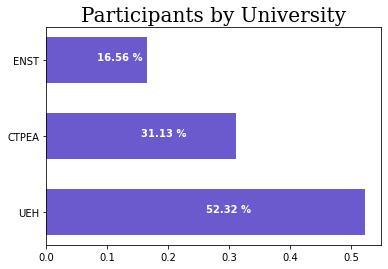

In [615]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

def BarHPlot(x, tit):
  d = data[x].value_counts()
  col = data[x].value_counts(normalize=True)
  g = plt.barh(col.index, height=.6, width=col, color="slateblue")
  
  for i, v in enumerate(col):
    plt.text(v/2, i, str(round(v*100,2))+" %", color='w', fontweight='bold')
  plt.title(tit, fontsize=20, fontdict=font)
  plt.savefig(tit+".png")
  return d, col, g


d, g, f = BarHPlot('nom_univ1', "Participants by University")

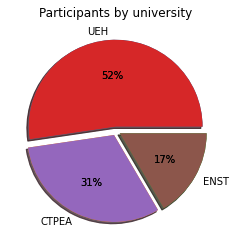

In [616]:
PieChart(data=data.nom_univ1, tit = "Participants by university")


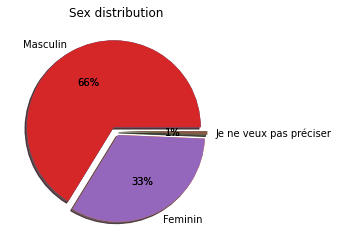

In [617]:
PieChart(data.sexe, "Sex distribution")

In [618]:
def BivPlot(data=data, col1 = "", col2 = "", lable1 = [], labels2 = [], tit="", ):
  tab = pd.crosstab(data[col1], data[col2])
  tab.plot(kind='bar')
  plt.xticks(rotation = 0)

  plt.show()

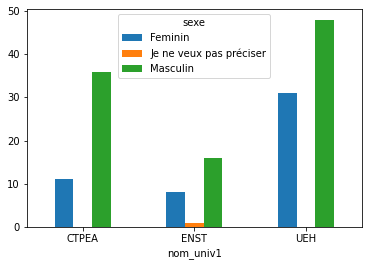

In [619]:
BivPlot(col2="sexe", col1='nom_univ1')

(Ouest         98
 Nord          22
 Artibonite    11
 Sud            6
 Nord-Ouest     4
 Nord-Est       4
 Centre         3
 Sud-Est        3
 Name: bdep, dtype: int64, Ouest         0.649007
 Nord          0.145695
 Artibonite    0.072848
 Sud           0.039735
 Nord-Ouest    0.026490
 Nord-Est      0.026490
 Centre        0.019868
 Sud-Est       0.019868
 Name: bdep, dtype: float64, <BarContainer object of 8 artists>)

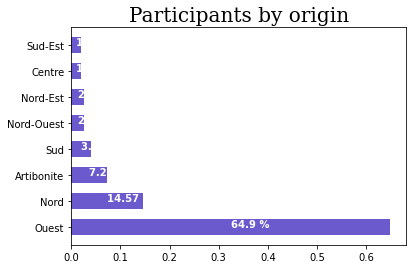

In [620]:
BarHPlot('bdep', 'Participants by origin')

(Ouest         109
 Nord           21
 Artibonite      9
 Sud-Est         4
 Sud             4
 Nord-Ouest      2
 Nord-Est        1
 Centre          1
 Name: dep_terminal, dtype: int64, Ouest         0.721854
 Nord          0.139073
 Artibonite    0.059603
 Sud-Est       0.026490
 Sud           0.026490
 Nord-Ouest    0.013245
 Nord-Est      0.006623
 Centre        0.006623
 Name: dep_terminal, dtype: float64, <BarContainer object of 8 artists>)

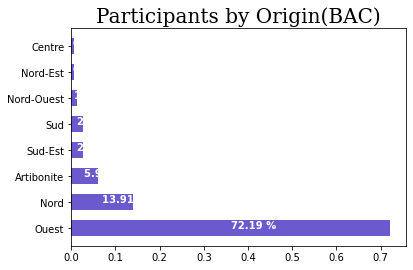

In [621]:
BarHPlot('dep_terminal', "Participants by Origin(BAC)")

Series([], dtype: int64)

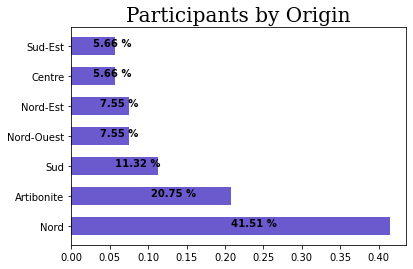

In [622]:
dbTemp = data[data.bdep != "Ouest"]

y = len(dbTemp)
x = sum(dbTemp['depdiff'])
f = ""
f += str(x/y)+" It's the proportion des etudiants non originaire de l'\Ouest qui y viennent juste pour l'universite"

def BarHPlotsp(x, tit):
  d = data[data[x] != "Ouest"].value_counts()
  col = data[data[x] != "Ouest"][x].value_counts(normalize=True)
  g = plt.barh(col.index, height=.6, width=col, color="slateblue")
  
  for i, v in enumerate(col):
    plt.text(v/2, i, str(round(v*100,2))+" %", color='black', fontweight='bold')
  plt.title(tit, fontsize=20, fontdict=font)
  plt.savefig(tit+".png")
  return d, col, g
d, g, f = BarHPlotsp('bdep', "Participants by Origin")
d

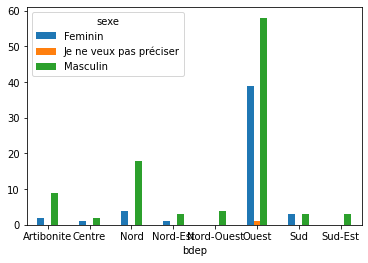

In [623]:
BivPlot(col2="sexe", col1="bdep")

In [624]:
data.age.mean()

23.2317880794702

In [625]:
data.age.median()

23.0

All student age distribution


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


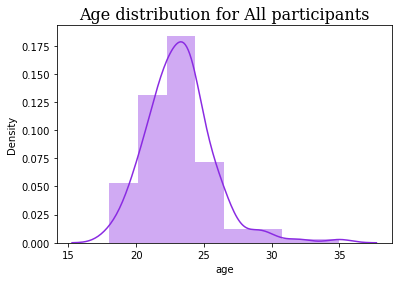

3.5043706588129524 1.112835318556592
Normality Test for Age:
P-value = 0.0. Then We reject the hypothesis: the age's distribution of students are noraml
0.0
CTPEA age Distribution


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


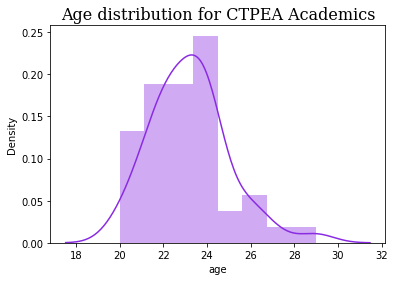

1.1712893781596803 0.7488222871083512
Normality Test for Age:
P-value = 0.03. Then We reject the hypothesis: the age's distribution of students are noraml
0.03
ENST age Distribution


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


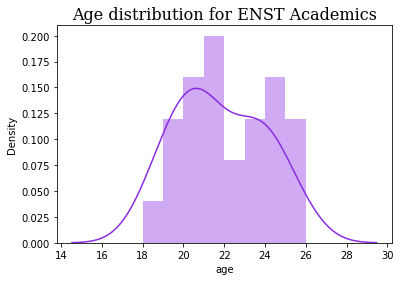

-1.0347800237812126 0.1632838318453378
Normality Test for Age:
P-value = 0.54. Then The data don't give us enough informations to say that the age's distribution of students are not noraml
UEH age Distribution


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


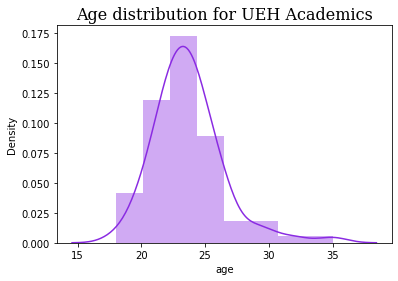

3.2779452680733883 1.2670174456061987
Normality Test for Age:
P-value = 0.0. Then We reject the hypothesis: the age's distribution of students are noraml
0.0


In [626]:
def AgeDist(df, cat):

  sns.distplot(df['age'], color='blueviolet', bins=8)
  tit = "Age distribution for "+cat
  plt.title(tit,fontdict=font,)
  plt.savefig(tit+".png")
  plt.show()

  kurtosis = stats.kurtosis(df.age)
  skewness = stats.skew(df.age)
  print(kurtosis, skewness)
  st, pv = stats.jarque_bera(df.age)
  f = "Normality Test for Age:\n"
  f += "P-value = "+str(round(pv, 2))+". Then "
  if pv < 0.05:
    f += "We reject the hypothesis: the age's distribution of students are noraml"
    print(f)
    print(round(pv,2))
  else:
    f += "The data don't give us enough informations to say that the age's distribution of students are not noraml"
    print(f)
  return f
print("All student age distribution")
f = AgeDist(data, "All participants")
print("CTPEA age Distribution")
f = AgeDist(data[data['nom_univ1']=="CTPEA"], "CTPEA Academics")
print("ENST age Distribution")
f = AgeDist(data[data['nom_univ1']=="ENST"], "ENST Academics")
print("UEH age Distribution")
f = AgeDist(data[data['nom_univ1']=="UEH"], "UEH Academics")


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


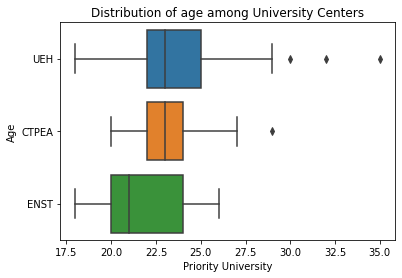

In [627]:
sns.boxplot(data.age, data.nom_univ1)
plt.xlabel("Priority University")
plt.ylabel("Age")
plt.title("Distribution of age among University Centers")
plt.show()

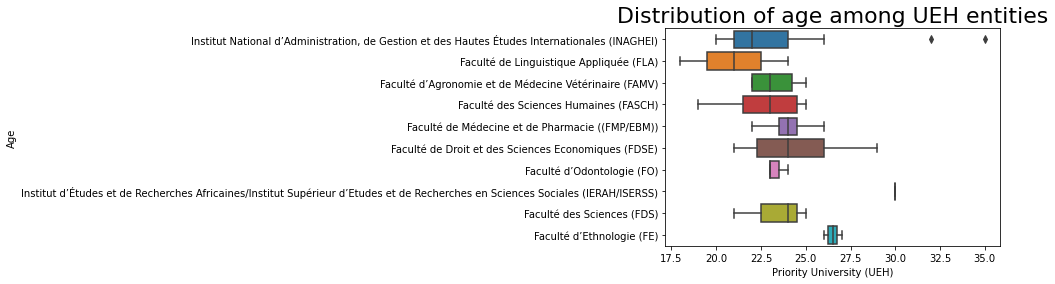

In [628]:


sns.boxplot(y = data.fac1, x = data.age)
plt.xlabel("Priority University (UEH)")
plt.title("Distribution of age among UEH entities", size = 22)
plt.ylabel("Age")
plt.show()

(Congréganiste (Frères, Soeurs)    91
 Privee                            34
 Lycee                             25
 other                              1
 Name: type_school_t, dtype: int64, Congréganiste (Frères, Soeurs)    0.602649
 Privee                            0.225166
 Lycee                             0.165563
 other                             0.006623
 Name: type_school_t, dtype: float64, <BarContainer object of 4 artists>)

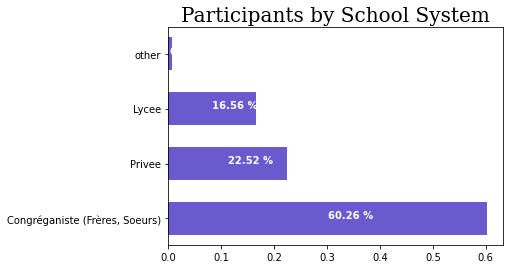

In [629]:
BarHPlot('type_school_t', "Participants by School System")

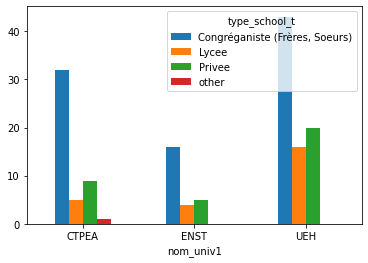

In [630]:
BivPlot(col1="nom_univ1", col2="type_school_t")

the same order of school origin

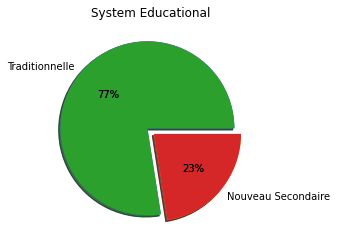

In [631]:
PieChart(data.system, "System Educational")

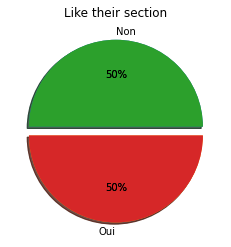

In [632]:
PieChart(data.love_sect, "Like their section")

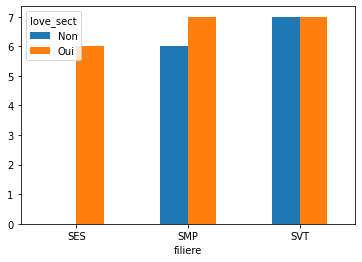

In [633]:
BivPlot(data = data[data['system']=="Nouveau Secondaire"], col1="filiere", col2="love_sect")

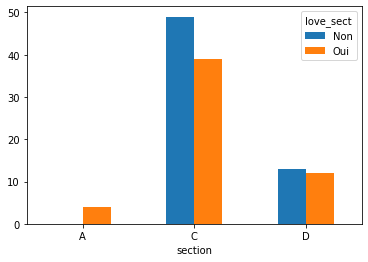

In [634]:
BivPlot(data = data[data['system']=="Traditionnelle"], col1="section", col2="love_sect")


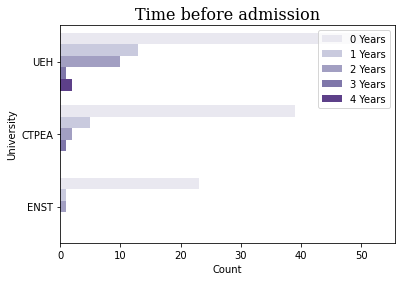

In [635]:
sns.countplot(data=data, y = "nom_univ1", palette="Purples", hue="paf",)
plt.title("Time before admission", fontdict=font)
plt.xlabel("Count")
plt.ylabel("University")
plt.legend(["0 Years", "1 Years", "2 Years", "3 Years", "4 Years"])
plt.savefig("Time before admission.png")
plt.show()

In [636]:
f = "UEH students take 0 to 4 years before integrate it"
f += "CTPEA students take 0 to 3 years before integrate it"
f += "ENST students take 0 to 3 years before integrate it"
insights += f

(Oui    119
 Non     32
 Name: prefac, dtype: int64, Oui    0.788079
 Non    0.211921
 Name: prefac, dtype: float64, <BarContainer object of 2 artists>)

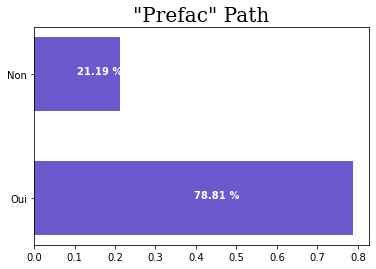

In [637]:
BarHPlot('prefac', "\"Prefac\" Path")

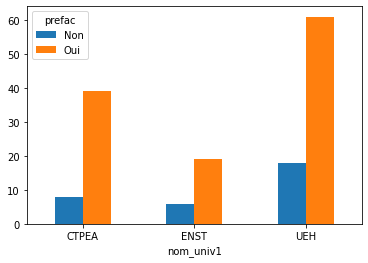

In [638]:
BivPlot(col2="prefac", col1="nom_univ1")

In [639]:
dbTemp3 = data[["prefac", "nom_univ1"]]
dbTemp3['prefac'] = dbTemp3.prefac.replace({"Oui":1, "Non": 0})
dbTemp3.groupby(by="nom_univ1").mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,prefac
nom_univ1,
CTPEA,0.829787
ENST,0.760000
UEH,0.772152


Participation en prefac

In [640]:
counts_on_data = data.groupby(by="nom_univ1").sum()

In [641]:
counts_on_data

,age,rcom_other,type_school_f_other,moyenne,inscri/ueh,inscri/ctpea,inscri/enst,ueh_fac/ens,ueh_fac/famv,ueh_fac/fasch,ueh_fac/fds,ueh_fac/fdse,ueh_fac/fe,ueh_fac/fla,ueh_fac/fmp,ueh_fac/fo,ueh_fac/fdsegch,ueh_fac/ierah,ueh_fac/inaghei,raison_fdsegch,raison_ens,admission/ueh,admission/ctpea,admission/enst,ueh_fac_admission/ens,ueh_fac_admission/famv,ueh_fac_admission/fasch,ueh_fac_admission/fds,ueh_fac_admission/fdse,ueh_fac_admission/fe,ueh_fac_admission/fla,ueh_fac_admission/fmp,ueh_fac_admission/fo,ueh_fac_admission/fdsegch,ueh_fac_admission/ierah,ueh_fac_admission/inaghei,paf,nb_univ,univ_1,anne1,nb_reprises,duree,univ_2,anne2,nb_reprises2,duree2,yCTPEA,yENST,yUEH,depdiff,nb_inscriptions
nom_univ1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CTPEA,1091.0,0.0,0.0,334.0,31.0,47.0,12.0,5.0,1.0,1.0,14.0,16.0,0.0,0.0,0.0,0.0,1.0,0.0,16.0,0.0,0.0,26.0,47.0,8.0,2.0,0.0,0.0,9.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,12.0,20.0,0.0,191.0,42.0,190.0,0.0,26.0,8.0,40.0,0,0,0,43,90.0
ENST,545.0,0.0,0.0,179.0,18.0,9.0,25.0,0.0,1.0,0.0,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,14.0,5.0,25.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,3.0,18.0,0.0,76.0,6.0,76.0,0.0,20.0,11.0,36.0,0,0,0,21,52.0
UEH,1872.0,0.0,0.0,529.0,79.0,12.0,6.0,1.0,5.0,11.0,12.0,29.0,4.0,3.0,9.0,3.0,0.0,2.0,24.0,0.0,0.0,79.0,3.0,4.0,1.0,5.0,9.0,9.0,29.0,4.0,3.0,7.0,3.0,0.0,2.0,20.0,44.0,18.0,0.0,349.0,103.0,348.0,0.0,23.0,12.0,31.0,0,0,0,68,97.0


total of inscriptions

In [642]:
count_insc = counts_on_data[["inscri/ueh",	"inscri/ctpea",	"inscri/enst"]]
u = count_insc.sum(axis=0,)
print(u, "\n", u.sum())

insights += "Total subscriptions are "+str(u.sum())

inscri/ueh      128.0
inscri/ctpea     68.0
inscri/enst      43.0
dtype: float64 
 239.0


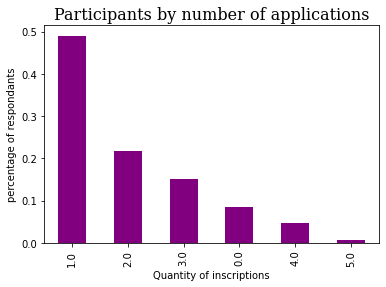

In [643]:
count_insc_mean = data[['inscri/ctpea',
       'inscri/enst', 'ueh_fac/ens', 'ueh_fac/famv',
       'ueh_fac/fasch', 'ueh_fac/fds', 'ueh_fac/fdse', 'ueh_fac/fe',
       'ueh_fac/fla', 'ueh_fac/fmp', 'ueh_fac/fo']]
count_insc_mean.sum(axis=1).value_counts(normalize=True).plot(kind='bar', color='purple')
plt.xlabel("Quantity of inscriptions")
plt.ylabel("percentage of respondants")
plt.title("Participants by number of applications", fontdict=font)
plt.savefig("Quantity of applications.png")

In [644]:
col_npl = ['raison_famv', 'raison_fasch',
       'raison_fds', 'raison_fdse', 'raison_fe', 'raison_fla', 'raison_fmp',
       'raison_fo', 'raison_fdsegch', 'raison_ierah', 'raison_inaghei',
       'raison_ctpea', 'raison_enst', 'raison_ens']

In [645]:

def WordMap(x, y):
  print(y)
  text2 = []
  for el in text:
    nl = el.split(' ')
    text2+=nl

  text3 = [x for x in text2 if len(x) >= 8]

  text4 = " ".join(text3)

  word_cloud = WordCloud(collocations = False, background_color = 'white',).generate(text4)

  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

CTPEA


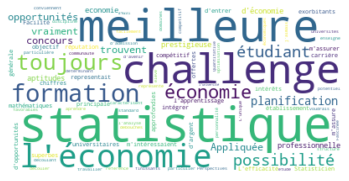

<Figure size 432x288 with 0 Axes>

In [646]:
text = data['raison_ctpea'].dropna().to_list()
WordMap(text, "CTPEA")
plt.savefig("CTPEA raison.png")

ENST


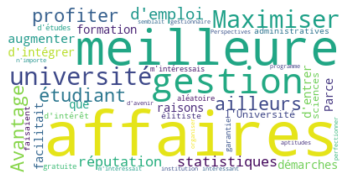

<Figure size 432x288 with 0 Axes>

In [647]:
text = data['raison_enst'].dropna().to_list()
WordMap(text, "ENST")
plt.show()
plt.savefig("ENST raison.png")

FDSE


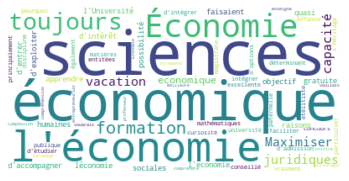

<Figure size 432x288 with 0 Axes>

In [648]:
text = data['raison_fdse'].dropna().to_list()
WordMap(text, "FDSE")
plt.savefig("FDSE raison1.png")

INAGHEI


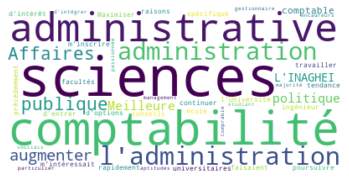

<Figure size 432x288 with 0 Axes>

In [649]:
text = data['raison_inaghei'].dropna().to_list()
WordMap(text, "INAGHEI")
plt.show()
plt.savefig("INAGHEI raison1.png")

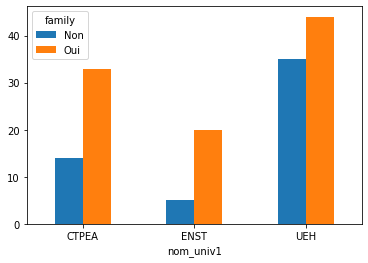

In [650]:
BivPlot(data=data,col1="nom_univ1", col2="family")

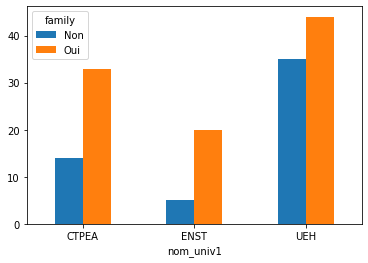

In [651]:
BivPlot(col1="nom_univ1", col2="family")

In [652]:
data[["nom_univ1", "family"]].replace({"Oui":1, "Non":0}).groupby(by="nom_univ1").mean()

,family
nom_univ1,
CTPEA,0.702128
ENST,0.800000
UEH,0.556962


In [653]:
data[["nom_univ1", "scolarite_parent"]].replace({"Oui":1, "Non":0}).groupby(by="nom_univ1").mean()

,scolarite_parent
nom_univ1,
CTPEA,0.893617
ENST,0.960000
UEH,0.772152


In [654]:
data[["nom_univ1", "scolarite_parent"]].replace({"Oui":1, "Non":0}).groupby(by="nom_univ1").sum()

,scolarite_parent
nom_univ1,
CTPEA,42
ENST,24
UEH,61


In [655]:
#UEH      79
#CTPEA    47
#ENST     25

from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest([42, 24], [47,25])
print("CTPEA vs ENST")
print('{0:0.3f}'.format(pval))
if pval < .05:
  print("We reject the null hypothesis")
else:
  print("The proportion are the same at 95% of confidence")


stat, pval = proportions_ztest([61, 24], [79,25])
print("\n\nUEH vs ENST")
print('{0:0.3f}'.format(pval))
if pval < .05:
  print("We reject the null hypothesis. The proportion are different")
else:
  print("The proportion are the same at 95% of confidence")


CTPEA vs ENST
0.332
The proportion are the same at 95% of confidence


UEH vs ENST
0.034
We reject the null hypothesis. The proportion are different


In [656]:
list_for_cl = []

def chartrelation(data, col1 = "", col2 = "",):
  tab = pd.crosstab(data[col1], data[col2])
  stat, p, dof, expected = stats.chi2_contingency(tab)

  f = "Test Khi square of independance betwenn the Univesity and the educational system.\n"
  if p < 0.1:
    ft = "We reject the null Hypothesis of independance between "+col1+" and "+col2+" ."
    list_for_cl.append(col2)
  else:
    ft = "The data don't give us enough informations to say that "+col1+" and "+col2+" are dependant."
  f+=ft
  print(f)
  return f+"\n"

## LAUREATE FUNCTION TO PERFORM

In [657]:
insights += chartrelation(data, "nom_univ1", "system")

Test Khi square of independance betwenn the Univesity and the educational system.
We reject the null Hypothesis of independance between nom_univ1 and system .


In [658]:
insights += chartrelation(data, "nom_univ1", "filiere")

Test Khi square of independance betwenn the Univesity and the educational system.
We reject the null Hypothesis of independance between nom_univ1 and filiere .


In [659]:
insights += chartrelation(data, "nom_univ1", "section")

Test Khi square of independance betwenn the Univesity and the educational system.
We reject the null Hypothesis of independance between nom_univ1 and section .


In [660]:
insights += chartrelation(data, "nom_univ1", "let_level")

Test Khi square of independance betwenn the Univesity and the educational system.
The data don't give us enough informations to say that nom_univ1 and let_level are dependant.


In [661]:
insights += chartrelation(data, "nom_univ1", "parent_revenu")

Test Khi square of independance betwenn the Univesity and the educational system.
The data don't give us enough informations to say that nom_univ1 and parent_revenu are dependant.


In [662]:
insights += chartrelation(data, "nom_univ1", "parent_revenu")

Test Khi square of independance betwenn the Univesity and the educational system.
The data don't give us enough informations to say that nom_univ1 and parent_revenu are dependant.


# **MACHINE LEARNING**

In [663]:
# lIST UTILITIES

In [664]:
list_for_ml = ['sexe', 'type_school_f', 'type_school_t', 'section', 'filiere', 'let_level', 'prefac', 'parent_revenu', 'let_level',]

univs = ['ctpea', 'ueh', 'enst']

## **PROFILING FOR EACH ENTITY**

> ## **Profil  for CTPEA**

In [665]:
ctpeaD = data[(data['inscri/ctpea'] == 1)]['admission/ctpea']
ctpeaD_df = data[(data['inscri/ctpea'] == 1)]

In [666]:
df_for_ml_n = ctpeaD_df[['moyenne',]]

In [667]:
df_for_ml_n

,moyenne
1,8.0
2,7.0
5,7.0
6,7.0
10,8.0
...,...
147,6.0
149,6.0
155,8.0
156,8.0


In [668]:
print(sum(ctpeaD), len(ctpeaD))

55.0 68


In [669]:

for el in list_for_ml:
  new_df = pd.get_dummies(ctpeaD_df[[el]], prefix=None, prefix_sep='')
  df_for_ml_n = pd.concat([df_for_ml_n, new_df.iloc[:,:-1]], axis=1)


In [670]:
from statsmodels.discrete.discrete_model import Logit, Probit

df_for_ml_n = np.asarray(df_for_ml_n, dtype=float)
ctpeaD = np.asarray(ctpeaD)
model = Probit(ctpeaD, df_for_ml_n, check_rank=True)
probit_model = model.fit()
print(probit_model.summary())


         Current function value: 0.369439
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                   68
Model:                         Probit   Df Residuals:                       50
Method:                           MLE   Df Model:                           17
Date:                Sat, 25 Sep 2021   Pseudo R-squ.:                  0.2428
Time:                        17:21:24   Log-Likelihood:                -25.122
converged:                      False   LL-Null:                       -33.179
Covariance Type:            nonrobust   LLR p-value:                    0.5158
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5815      0.364      1.598      0.110      -0.132       1.295
x2            -0.5155      0.593     -0.869      0.385      -1.67

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [671]:
probit_model.pred_table()

array([[ 3., 10.],
       [ 1., 54.]])

In [701]:
print("Accuracy : ", (3+54)*100/(3+54+10+1),"%")
print("Recall : ",round((54)*100/(54+1),2)," %")
print("Precision : ",round((54)*100/(54+10),2)," %")

Accuracy :  83.82352941176471 %
Recall :  98.18  %
Precision :  84.38  %


> ## **Profil  for ENST**

In [672]:
enstD = data[(data['inscri/enst'] == 1)]['admission/enst']
enstD_df = data[(data['inscri/enst'] == 1)]

In [673]:
df_for_ml_n2 = enstD_df[['moyenne',]]

In [674]:

for el in list_for_ml:
  new_df2 = pd.get_dummies(enstD_df[[el]], prefix=None, prefix_sep='', dummy_na=False)
  df_for_ml_n2 = pd.concat([df_for_ml_n2, new_df2.iloc[:,:-1]], axis=1,)


In [675]:
print(sum(enstD),len(enstD))

37.0 43


In [676]:
df_for_ml_n2.sum(axis=0)

moyenne                                                       305.0
sexeFeminin                                                    12.0
sexeJe ne veux pas préciser                                     1.0
type_school_fCongréganiste (Frères, Soeurs)                    24.0
type_school_fLycee                                              4.0
type_school_tCongréganiste (Frères, Soeurs)                    27.0
type_school_tLycee                                              7.0
sectionC                                                       25.0
filiereSES                                                      3.0
filiereSMP                                                      7.0
let_levelBalance(e)                                             9.0
let_levelBon en chiffre et nul(le) en lettre                    1.0
let_levelJ'étais cale en chiffre et en lettre/mémorisation     15.0
let_levelMeilleur en chiffre qu'en lettre                      12.0
let_levelMeilleur(e) en lettre/mémorisation qu'e

In [677]:
df_for_ml_n2 = pd.concat([enstD, df_for_ml_n2], axis=1,)

In [678]:
df_for_ml_n2.drop_duplicates(inplace=True)
print(len(df_for_ml_n2))

41


In [679]:
df_for_ml_n2.head()

,admission/enst,moyenne,sexeFeminin,sexeJe ne veux pas préciser,"type_school_fCongréganiste (Frères, Soeurs)",type_school_fLycee,"type_school_tCongréganiste (Frères, Soeurs)",type_school_tLycee,sectionC,filiereSES,filiereSMP,let_levelBalance(e),let_levelBon en chiffre et nul(le) en lettre,let_levelJ'étais cale en chiffre et en lettre/mémorisation,let_levelMeilleur en chiffre qu'en lettre,let_levelMeilleur(e) en lettre/mémorisation qu'en chiffre,prefacNon,parent_revenuNon,let_levelBalance(e),let_levelBon en chiffre et nul(le) en lettre,let_levelJ'étais cale en chiffre et en lettre/mémorisation,let_levelMeilleur en chiffre qu'en lettre,let_levelMeilleur(e) en lettre/mémorisation qu'en chiffre
4,1.0,6.0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
6,1.0,7.0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
7,1.0,8.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0
8,1.0,5.0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
10,1.0,8.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0


In [680]:
#enstD = np.asarray(df_for_ml_n2['admission/enst'])
#df_for_ml_n2 = df_for_ml_n2.drop(columns=["admission/enst"])
#df_for_ml_n2 = np.asarray(df_for_ml_n2, dtype=float)
#model2 = Logit(enstD, df_for_ml_n2, check_rank=True, )
#probit_model2 = model2.fit()
#print(probit_model2.summary())

         Current function value: inf
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: ignored

> ## **Profil  for UEH**

In [682]:
uehD = data[(data['inscri/ueh'] == 1)]['admission/ueh']
uehD_df = data[(data['inscri/ueh'] == 1)]

In [683]:
df_for_ml_n3 = uehD_df[['moyenne',]]

In [684]:
for el in list_for_ml:
  new_df = pd.get_dummies(uehD_df[[el]], prefix=None, prefix_sep='')
  df_for_ml_n3 = pd.concat([df_for_ml_n3, new_df.iloc[:,:-1]], axis=1,)


In [685]:
df_for_ml_n3 = pd.concat([uehD, df_for_ml_n3], axis=1,)

In [686]:
df_for_ml_n3.drop_duplicates(inplace=True)
print(len(df_for_ml_n3))

114


In [687]:
uehD = np.asarray(df_for_ml_n3['admission/ueh'])
df_for_ml_n3 = df_for_ml_n3.drop(columns=["admission/ueh"])

In [688]:
df_for_ml_n3 = np.asarray(df_for_ml_n3, dtype=float)
uehD = np.asarray(uehD)
model3 = Logit(uehD, df_for_ml_n3, check_rank=False, )
probit_model3 = model3.fit()
print(probit_model3.summary())

         Current function value: 0.165268
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  114
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                           17
Date:                Sat, 25 Sep 2021   Pseudo R-squ.:                  0.4016
Time:                        17:21:46   Log-Likelihood:                -18.841
converged:                      False   LL-Null:                       -31.486
Covariance Type:            nonrobust   LLR p-value:                   0.08840
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0502      0.207      0.242      0.808      -0.356       0.456
x2            20.5667   1.29e+04      0.002      0.999   -2.54e+0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [689]:
probit_model3.pred_table()

array([[  4.,   5.],
       [  1., 104.]])

In [700]:
print("Accuracy : ",round((4+104)*100/(4+104+5+1),2)," %")
print("Recall : ",round((104)*100/(104+1),2)," %")
print("Precision : ",round((104)*100/(104+5),2)," %")

Accuracy :  94.74  %
Recall :  99.05  %
Precision :  95.41  %


# Reflections
## Summary of Data Analysis
- What insights should the user takeaway from EDA.

## Questions unanswered
- What aspects of the research question were we unable to answer and why?
> Perform a regression prediction on universities because we dont have data of all persons who tried to integrated these universities

## Recommendations
- What should the reader do next with this information?
> North Departement need a University when we refer to the origin of students
> 0.3018867924528302 It's the proportion des etudiants non originaire de l'\Ouest qui y viennent juste pour l'universite
Artibonite    0.2500
Nord          0.1875
Nord-Est      0.1875
Nord-Ouest    0.1250
Centre        0.1250
Sud           0.1250
Artibonite, Nord and Nord-Ouest are the most concerned
## Next Steps
- What will the analyst do next based on the analysis?

In [690]:
#Notes analysis

#for each entity, quel comportment adopter.

# yCTPEA = 1 si admis 0 sinon
# yENST = 1 si admis 0 sinon
# yUEH = 1 si admis 0 sinon

# ANALYSE I
# realiser une regression logistique pour chaque entite
# analyser la matrice de confusion
# analyser les coefficients


#Notes coding

#Set the background for visualizations
#Set the title size
#Set the colors to use

In [691]:
print(insights)

Le lien du questionnaire a ete touche par 161 repondants, dont 152 universitaires.
Parmis ces 152 universitaires, 151 ont accepter de participer a l'enquete.
Ce qui correspond a un taux de reponse de 0.993421052631579
Les analyses qui suivront concernent donc 151 universitaires.

UEH students take 0 to 4 years before integrate itCTPEA students take 0 to 3 years before integrate itENST students take 0 to 3 years before integrate itTotal subscriptions are 239.0Test Khi square of independance betwenn the Univesity and the educational system.
We reject the null Hypothesis of independance between nom_univ1 and system .
Test Khi square of independance betwenn the Univesity and the educational system.
We reject the null Hypothesis of independance between nom_univ1 and filiere .
Test Khi square of independance betwenn the Univesity and the educational system.
We reject the null Hypothesis of independance between nom_univ1 and section .
Test Khi square of independance betwenn the Univesity and 